# 1. 데이터 임베딩


In [3]:
import os
os.getcwd()

'/Users/hyo-cheolahn/Documents/Projects/Book-Recommendation/notebook'

In [ ]:
import json
import numpy as np
import re
from sentence_transformers import SentenceTransformer

# === 파일 경로 설정 ===
json_file_path = "../data/scraping/llm_output_fixed.json"  # JSON 파일 경로
embedding_save_path = "notebook/data/book_embeddings.npz"  # 임베딩 저장 경로

# === 모델 로드 ===
# Sentence-BERT 모델을 로드합니다. 필요에 따라 모델을 변경할 수 있습니다.
model = SentenceTransformer('all-MiniLM-L6-v2')

# === JSON 데이터 로드 ===
def load_book_data(json_file_path):
    """
    JSON 파일에서 책 데이터를 로드합니다.
    """
    with open(json_file_path, 'r', encoding='utf-8') as file:
        book_data = json.load(file)
        book_data = list(book_data.values())
    return book_data

# === 책 소개글 임베딩 ===
def embed_book_descriptions(book_data, model):
    """
    책 데이터의 소개글을 임베딩합니다.
    """

    messages = [book["sentence"] for book in book_data]
    hashtags = [re.findall(r'#(\S+)', book["hashtags"]) for book in book_data]

    # print(f"{len(messages) = }")
    # print(f"{len(hashtags) = }")
    # print(f"{hashtags}")

    book_content = [
        f"{message} {' '.join(tags)}" for message, tags in zip(messages, hashtags)
    ]
    # print(len(book_content))
    # print(book_content)

    embeddings = model.encode(messages, show_progress_bar=True)
    return embeddings

# === 임베딩 및 데이터 저장 ===
def save_embeddings(book_data, embeddings, save_path):
    """
    책 데이터와 임베딩 결과를 저장합니다.
    """
    ids = [book["isbn"] for book in book_data]
    np.savez_compressed(save_path, ids=ids, embeddings=embeddings)

# === 실행 ===
if __name__ == "__main__":
    # 책 데이터를 로드합니다.
    book_data = load_book_data(json_file_path)
    
    # 책 소개글을 임베딩합니다.
    print("Embedding book content...")
    embeddings = embed_book_descriptions(book_data, model)

    # 임베딩 결과를 저장합니다.
    print(f"Saving embeddings to {embedding_save_path}...")
    save_embeddings(book_data, embeddings, embedding_save_path)

    print("Embedding and saving complete.")

In [9]:
import numpy as np

# === 임베딩 로드 함수 ===
# def load_embeddings(file_path):
#     """
#     npz 파일에서 저장된 임베딩과 관련 데이터를 로드합니다.
#     """
#     # 저장된 데이터를 불러옴
#     data = np.load(file_path, allow_pickle=True)
#     ids = data['ids']  # ISBN 또는 기타 ID
#     embeddings = data['embeddings']  # 임베딩 벡터
#     return ids, embeddings


def load_embeddings(file_path):

    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    embeddings = [inner_dict["embedding"] for inner_dict in data.values()]
    ids = np.arange(1, len(embeddings) + 1)
    print("len(ids)!!!!!!!!!!!!!!!!!!!!!!!", len(ids))
    return ids, embeddings

# === 로드 및 사용 ===
if __name__ == "__main__":
    embedding_save_path = "/Users/hyo-cheolahn/Documents/Projects/Book-Recommendation/app/data/book_embeddings.json"  # 저장된 파일 경로

    # 임베딩 데이터를 로드합니다.
    ids, embeddings = load_embeddings(embedding_save_path)

    # 결과 출력
    print(f"Loaded {len(ids)} ids.")
    print(f"Loaded {len(embeddings)} embeddings.")
    print(f"First ID: {ids[0]}")
    # print(f"First embedding shape: {embeddings[0].shape}")
    print(f"First embedding vector: {embeddings[0]}")

len(ids)!!!!!!!!!!!!!!!!!!!!!!! 1781
Loaded 1781 ids.
Loaded 1781 embeddings.
First ID: 1
First embedding vector: [-0.00996169913560152, -0.0127776600420475, 0.02223261445760727, -0.04677444323897362, -0.025606635957956314, 0.024734264239668846, -0.02232241816818714, -0.014599374495446682, -0.024888211861252785, 0.007607582490891218, -0.016344115138053894, -0.0008046173024922609, -0.004368266090750694, -0.0011530041228979826, 0.0032200729474425316, -0.0006630976567976177, 0.0395132452249527, -0.028608614578843117, -0.011321570724248886, -0.009236861951649189, 0.01592075824737549, -0.009108572266995907, -0.009268934838473797, -0.02092405967414379, 0.0026940847747027874, 0.0011586168548092246, 0.02331024780869484, -0.019589845091104507, 0.014997072517871857, -0.02363097295165062, 0.03345796838402748, -0.0051540411077439785, -0.007440805900841951, -0.0015723513206467032, -0.009198375046253204, -0.02247636578977108, -0.002995565766468644, 0.006135457661002874, 0.01285463385283947, -0.01652

# 2. Thompson Sampling

In [7]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import beta


book_embeddings = embeddings
# books = [f"Book {i}" for i in range(len(ids))]
books = [f"Book {i}" for i in range(len(ids))]  # books는 ids의 길이에 따라 생성
assert len(books) == len(ids), "Books length mismatch with IDs!"
num_books = 1486
# === 클러스터링 ===

# KMeans 클러스터링 (50개의 클러스터로 나눔)
num_clusters = 12
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(book_embeddings)

# 각 클러스터의 책 인덱스 저장
cluster_to_books = {i: [] for i in range(num_clusters)}
for idx, cluster_id in enumerate(clusters):
    cluster_to_books[cluster_id].append(idx)

# 클러스터별 알파, 베타 값 초기화
alpha = np.ones(num_books)
beta_values = np.ones(num_books)

# 이미 제시된 책을 저장할 세트
presented_books = set()



### Optics


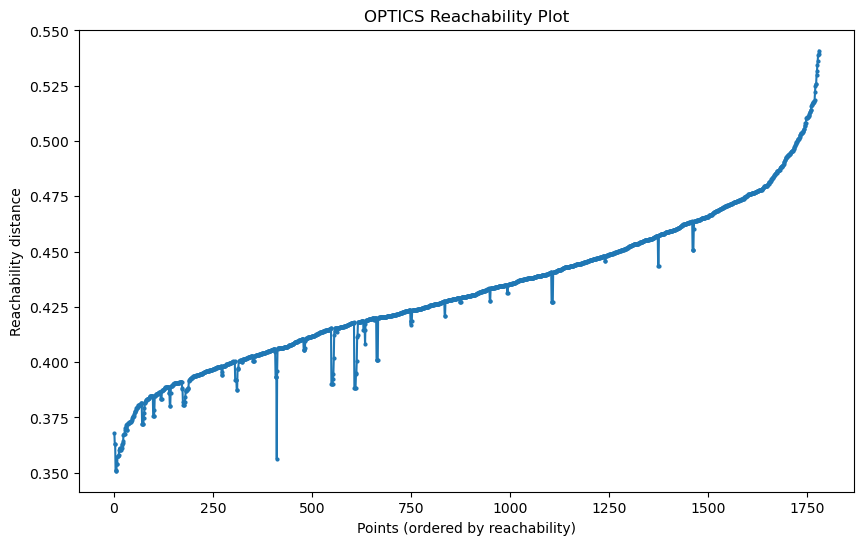

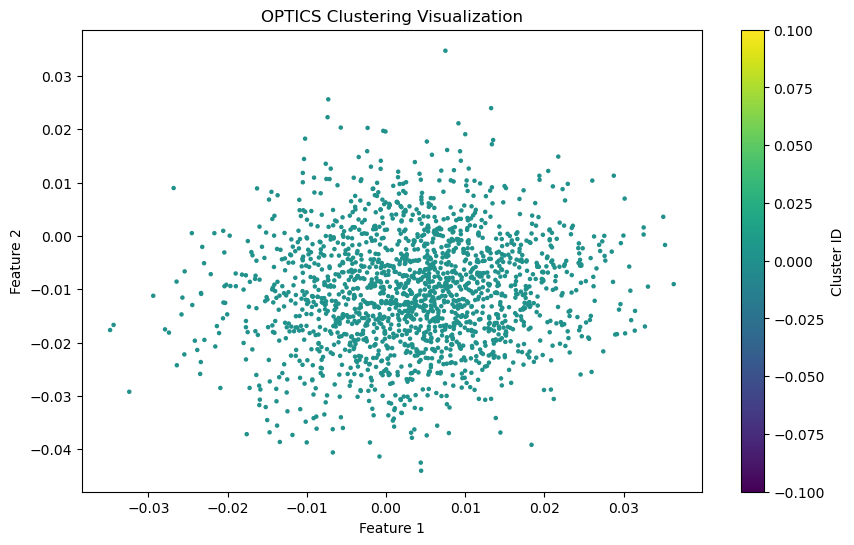

In [17]:
import numpy as np
from sklearn.cluster import OPTICS
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import beta
import hdbscan
import matplotlib.pyplot as plt

book_embeddings = embeddings
book_embeddings = np.array(book_embeddings)
books = [f"Book {i}" for i in range(len(ids))]
assert len(books) == len(ids), "Books length mismatch with IDs!"
num_books = 1486

# === 클러스터링 ===

# OPTICS 클러스터링
optics = OPTICS(min_samples=5, eps=0.4)
clusters = optics.fit_predict(book_embeddings)

# 각 클러스터의 책 인덱스 저장
cluster_to_books = {i: [] for i in set(clusters) if i != -1}
for idx, cluster_id in enumerate(clusters):
    if cluster_id != -1:
        cluster_to_books[cluster_id].append(idx)

# OPTICS 시각화 - Reachability Plot
reachability = optics.reachability_[optics.ordering_]
plt.figure(figsize=(10, 6))
plt.plot(reachability, marker='o', markersize=2)
plt.title('OPTICS Reachability Plot')
plt.xlabel('Points (ordered by reachability)')
plt.ylabel('Reachability distance')
plt.show()

# OPTICS 시각화 - 클러스터 결과
plt.figure(figsize=(10, 6))
plt.scatter(book_embeddings[:, 0], book_embeddings[:, 1], c=clusters, cmap='viridis', s=5)
plt.title('OPTICS Clustering Visualization')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster ID')
plt.show()


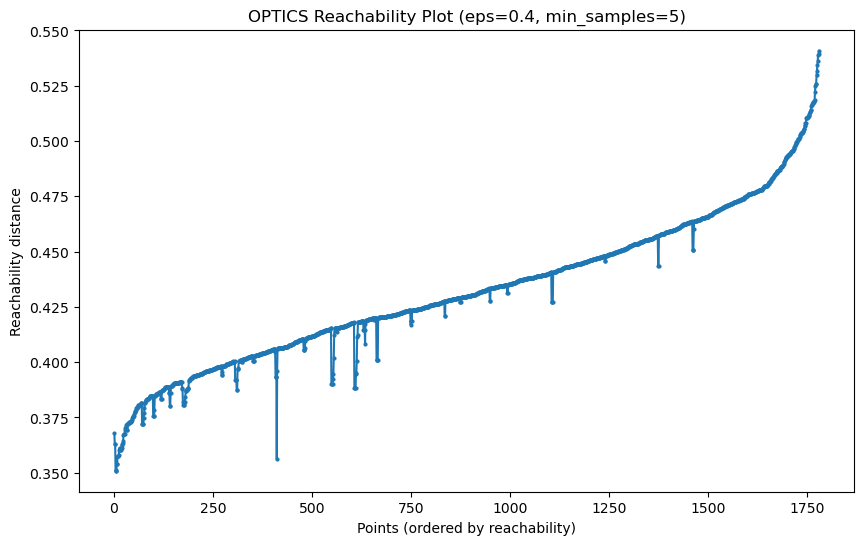

/opt/anaconda3/envs/mecab_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/mecab_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


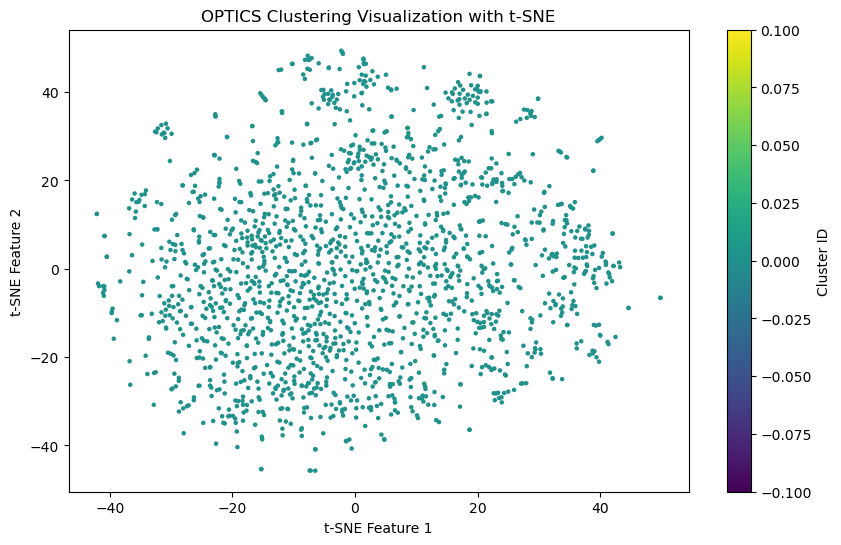

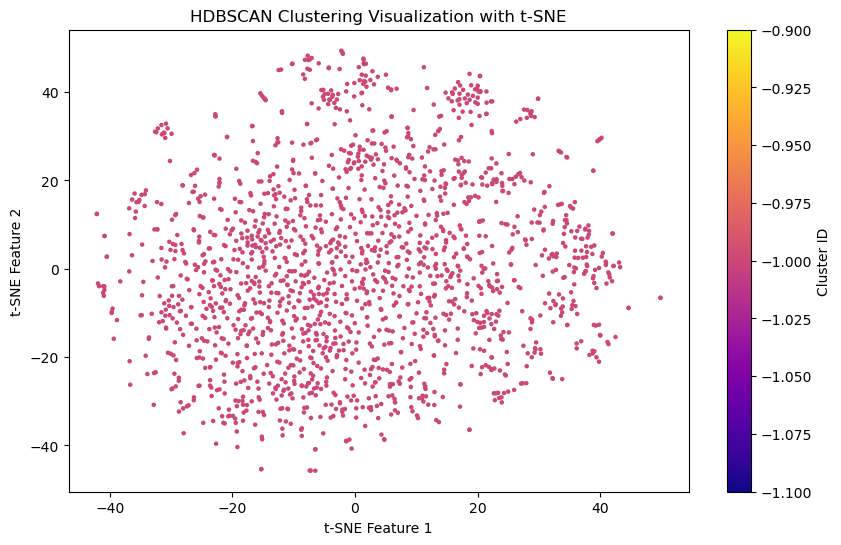

OPTICS 클러스터링 결과: {0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217

In [19]:
import numpy as np
from sklearn.cluster import OPTICS
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import beta
import hdbscan
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 데이터 설정
book_embeddings = np.array(embeddings)
books = [f"Book {i}" for i in range(len(ids))]
assert len(books) == len(ids), "Books length mismatch with IDs!"
num_books = 1486

# === OPTICS 클러스터링 (eps=0.4, min_samples=5) ===
optics = OPTICS(min_samples=5, eps=0.4)
clusters = optics.fit_predict(book_embeddings)

# 클러스터별 인덱스 저장
cluster_to_books = {i: [] for i in set(clusters) if i != -1}
for idx, cluster_id in enumerate(clusters):
    if cluster_id != -1:
        cluster_to_books[cluster_id].append(idx)

# OPTICS 시각화 - Reachability Plot
reachability = optics.reachability_[optics.ordering_]
plt.figure(figsize=(10, 6))
plt.plot(reachability, marker='o', markersize=2)
plt.title('OPTICS Reachability Plot (eps=0.4, min_samples=5)')
plt.xlabel('Points (ordered by reachability)')
plt.ylabel('Reachability distance')
plt.show()

# OPTICS 시각화 - 클러스터 결과 (2D 시각화)
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(book_embeddings)
plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters, cmap='viridis', s=5)
plt.title('OPTICS Clustering Visualization with t-SNE')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.colorbar(label='Cluster ID')
plt.show()

# === HDBSCAN 클러스터링 적용 ===
hdb = hdbscan.HDBSCAN(min_cluster_size=5)
hdb_clusters = hdb.fit_predict(book_embeddings)

# HDBSCAN 시각화
plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=hdb_clusters, cmap='plasma', s=5)
plt.title('HDBSCAN Clustering Visualization with t-SNE')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.colorbar(label='Cluster ID')
plt.show()

print("OPTICS 클러스터링 결과:", cluster_to_books)
print("HDBSCAN 클러스터링 결과:", set(hdb_clusters))

In [11]:
print(books[-10:])

['Book 1404', 'Book 1405', 'Book 1406', 'Book 1407', 'Book 1408', 'Book 1409', 'Book 1410', 'Book 1411', 'Book 1412', 'Book 1413']


In [4]:
print(len(ids))
print(len(books))

print(f"Length of ids: {len(ids)}")
print(f"Length of embeddings: {len(book_embeddings)}")

1486
1486
Length of ids: 1486
Length of embeddings: 1486


In [12]:
def thompson_sampling(alpha, beta_values):
    """
    Thompson Sampling을 수행하여 각 책의 확률 값을 샘플링.
    """
    return np.random.beta(alpha, beta_values)

def select_books(cluster_to_books, alpha, beta_values, presented_books):
    """
    클러스터 기반으로 책 쌍 선택.
    - 탐색과 활용의 균형을 맞춰 책을 선택.
    """
    # Thompson Sampling을 통해 각 책의 샘플링 값 계산
    samples = thompson_sampling(alpha, beta_values)

    # 클러스터별 대표 책 선택 (확률 값이 높은 책)
    representative_books = []
    for cluster_id, books_in_cluster in cluster_to_books.items():
        cluster_samples = [(idx, samples[idx]) for idx in books_in_cluster if idx not in presented_books]
        if cluster_samples:
            best_book = max(cluster_samples, key=lambda x: x[1])
            representative_books.append(best_book)

    # 대표 책들 중 가장 높은 샘플링 값을 가진 책 1개 선택
    if not representative_books:
        raise ValueError("No more books to present. All books have been used.")
    
    best_book_a = max(representative_books, key=lambda x: x[1])[0]

    # 탐색을 위해 랜덤한 책 선택
    random_book_b = np.random.choice(
        [idx for idx in range(num_books) if idx not in presented_books and idx != best_book_a]
    )

    # 중복 방지
    presented_books.add(best_book_a)
    presented_books.add(random_book_b)

    return best_book_a, random_book_b

def update_data(choice, book_a, book_b, alpha, beta_values):
    """
    사용자 선택 데이터를 기반으로 베타 분포 업데이트.
    """
    if choice == "a":
        alpha[book_a] += 1
        beta_values[book_b] += 1
    else:
        alpha[book_b] += 1
        beta_values[book_a] += 1

## 클러스터링 시각화

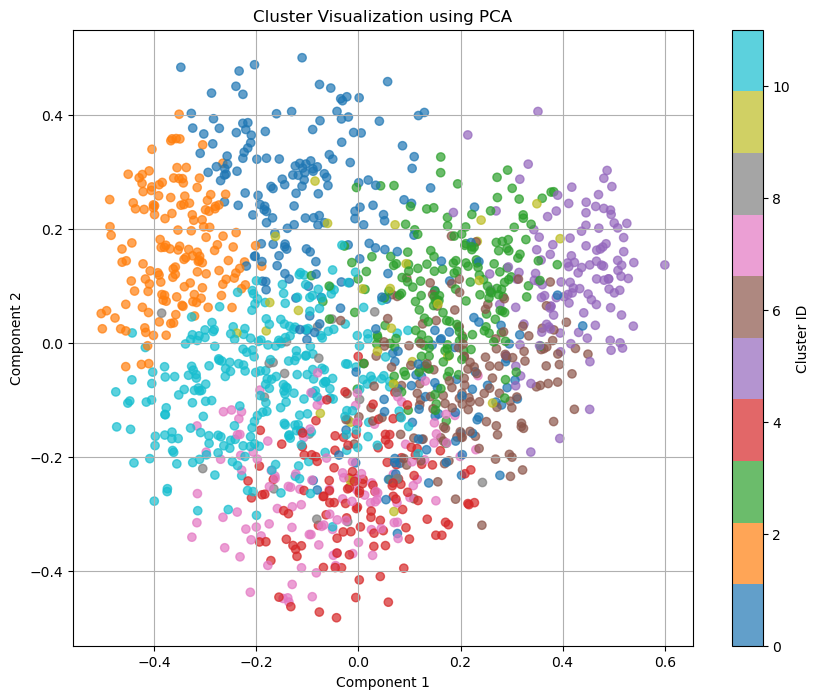

/opt/anaconda3/envs/mecab_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/mecab_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


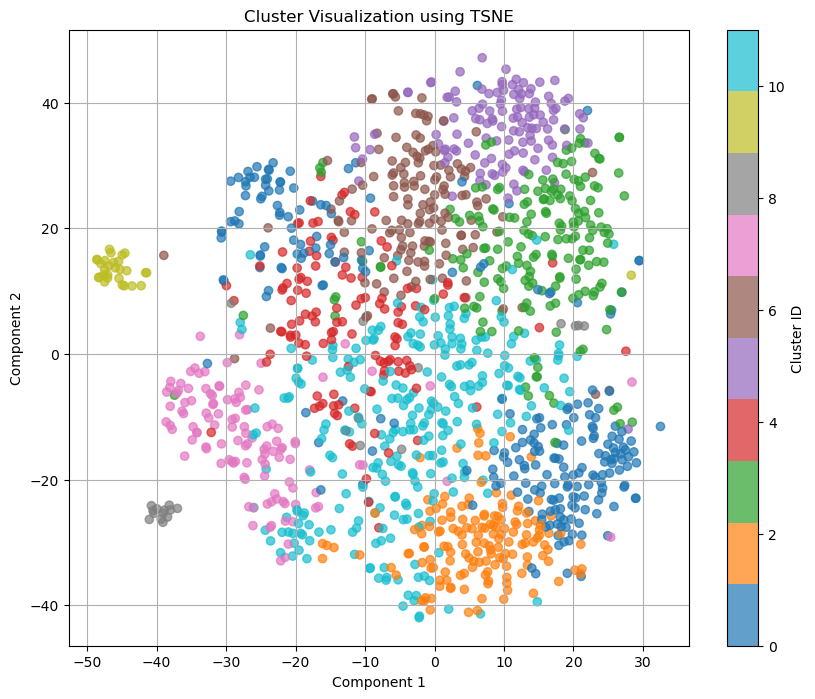

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 클러스터 결과 시각화
def visualize_clusters(embeddings, clusters, method="pca"):
    """
    책 임베딩과 클러스터 결과를 시각화합니다.
    - embeddings: 책 임베딩 (n_samples, n_features)
    - clusters: 클러스터 레이블 (n_samples,)
    - method: 'pca' 또는 'tsne'
    """
    # 차원 축소
    if method == "pca":
        reducer = PCA(n_components=2)  # PCA로 2D 축소
        reduced_embeddings = reducer.fit_transform(embeddings)
    elif method == "tsne":
        reducer = TSNE(n_components=2, random_state=42, perplexity=30)
        reduced_embeddings = reducer.fit_transform(embeddings)
    else:
        raise ValueError("Method must be 'pca' or 'tsne'.")

    # 시각화
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        reduced_embeddings[:, 0],  # 첫 번째 축
        reduced_embeddings[:, 1],  # 두 번째 축
        c=clusters,               # 클러스터 ID로 색상 지정
        cmap="tab10",             # 색상 팔레트
        alpha=0.7                 # 투명도
    )
    plt.colorbar(scatter, label="Cluster ID")
    plt.title(f"Cluster Visualization using {method.upper()}")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.show()

# 사용 예시
visualize_clusters(book_embeddings, clusters, method="pca")  # PCA 사용
visualize_clusters(book_embeddings, clusters, method="tsne")  # t-SNE 사용

In [15]:
# === 메인 루프 ===

def get_message_by_id(ids, book_id, book_data):
    """
    ids와 book_data를 이용해 특정 book_id의 메시지를 조회합니다.
    """
    idx = np.where(ids == book_id)[0][0]  # book_id의 인덱스 찾기
    return book_data[idx]["sentence"]

for round_num in range(10):
    # 클러스터 기반 책 쌍 선택
    book_a, book_b = select_books(cluster_to_books, alpha, beta_values, presented_books)

    # 책 메시지 조회
    message_a = get_message_by_id(ids, ids[book_a], book_data)
    message_b = get_message_by_id(ids, ids[book_b], book_data)

    # 사용자에게 책 제시
    print('\n')
    print(f"Round {round_num + 1}: Choose between:")
    print(f"a: {message_a}")
    print(f"b: {message_b}")
    
    # 사용자 입력
    choice = input("Enter 'a' or 'b': ").strip().lower()
    if choice not in ['a', 'b']:
        print("Invalid choice. Please enter 'a' or 'b'.")
        continue

    # 데이터 업데이트
    update_data(choice, book_a, book_b, alpha, beta_values)



Round 1: Choose between:
a: 코코의 눈은 우주를 담았어요. 함께한 추억, 무지개 너머에.
b: 수의사는 초조함으로 살아간다. 동물에게 생명을 맡기기에.


In [ ]:
# === 최종 추천 ===

# 사용자 선택 데이터를 기반으로 선호 중심 계산
selected_books = np.array(list(presented_books))
selected_embeddings = book_embeddings[selected_books]
weights = np.arange(1, len(selected_books) + 1)  # 가중치 추가
preference_center = np.average(selected_embeddings, axis=0, weights=weights).reshape(1, -1)

# 중심과 유사한 책 추천 (코사인 유사도 기준, 노이즈 추가)
similarities = cosine_similarity(preference_center, book_embeddings).flatten()
noise = np.random.uniform(0, 0.1, size=similarities.shape)  # 랜덤 노이즈 추가
noisy_similarities = similarities + noise
recommended_indices = np.argsort(noisy_similarities)[::-1][:10]

print("\nTop 10 Recommended Books:")
for idx in recommended_indices:
    # 책 ID를 이용해 메시지 조회
    book_id = ids[idx]
    message = get_message_by_id(ids, book_id, book_data)
    print(f"Book ID: {book_id}")
    print(f"Message: {message}\n")